In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/DataAnalyticsProject/data.csv'

In [ ]:
import pandas as pd
df = pd.read_csv(file_path, encoding='ISO-8859-1')  # 'latin1' also works
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Drop rows with missing customer ID
df.dropna(subset=['CustomerID'], inplace=True)

# Remove cancelled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Convert date column to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a new column for Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Sanity check
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,397924.000000,397924,397924.000000,397924.000000,397924.000000
mean,13.021823,2011-07-10 23:43:36.912475648,3.116174,15294.315171,22.394749
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000,0.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,180.420210,NaN,22.096788,1713.169877,309.055588


In [ ]:
# Create new time-based features
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.day_name()
df['Month'] = df['InvoiceDate'].dt.month_name()

Text(0, 0.5, 'Total Sales')

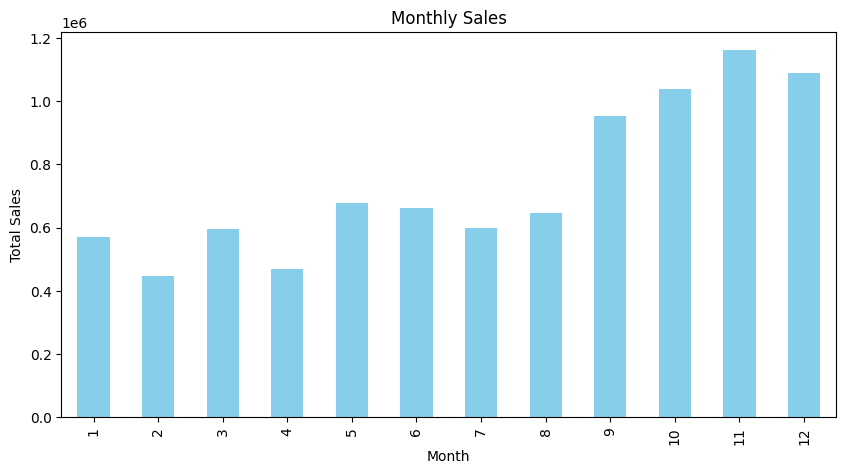

In [ ]:
df['MonthNum'] = df['InvoiceDate'].dt.month
monthly_sales = df.groupby('MonthNum')['TotalPrice'].sum()
monthly_sales.plot(kind='bar', title='Monthly Sales', figsize=(10,5), color='skyblue')
plt.xlabel("Month")
plt.ylabel("Total Sales")

Text(0.5, 0, 'Revenue')

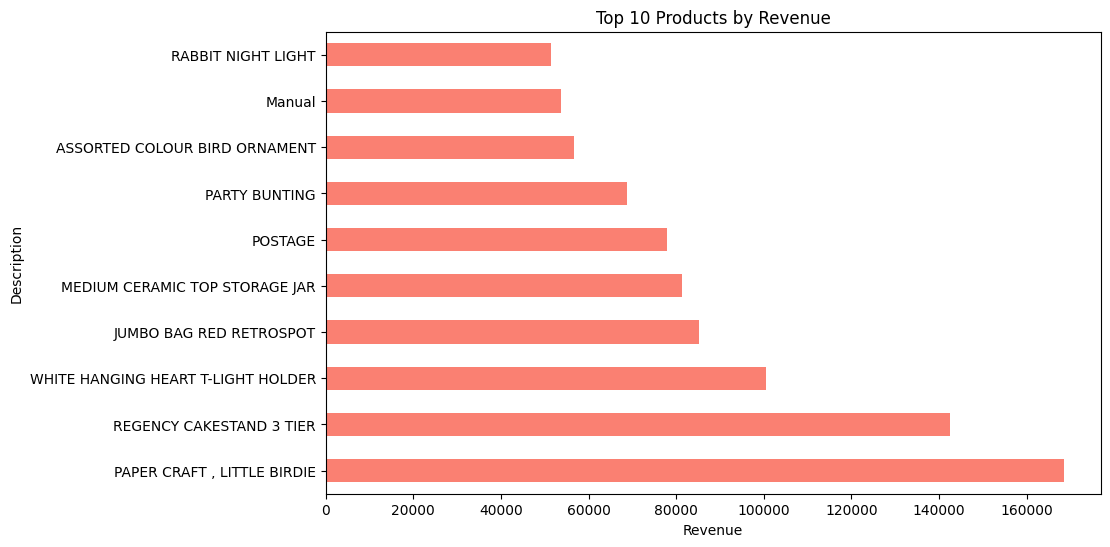

In [ ]:
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', figsize=(10,6), title='Top 10 Products by Revenue', color='salmon')
plt.xlabel("Revenue")

Text(0.5, 0, 'Total Sales')

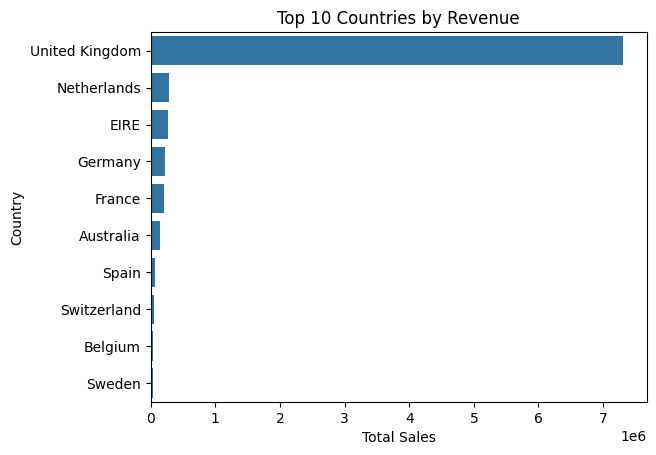

In [ ]:
top_countries = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Total Sales")

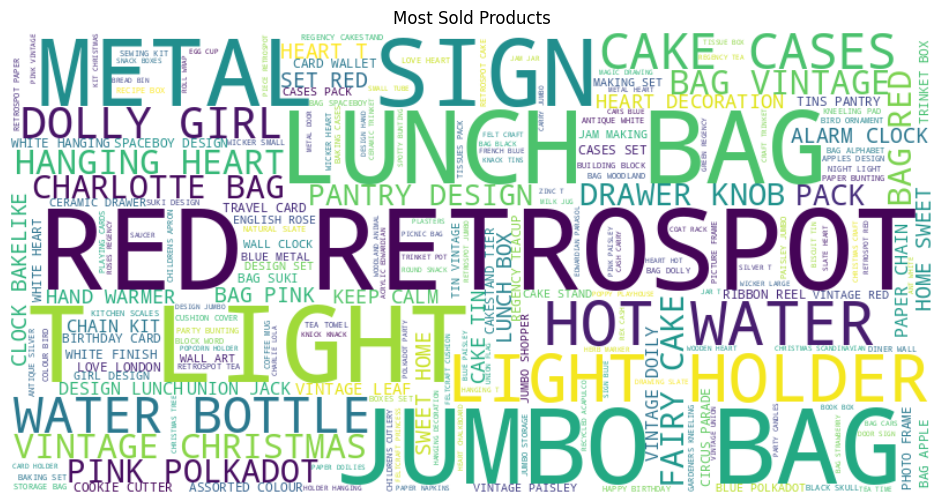

In [ ]:
text = ' '.join(df['Description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Sold Products')
plt.show()

In [ ]:
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]

In [ ]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

Text(0.5, 1.0, 'Distribution of RFM Scores')

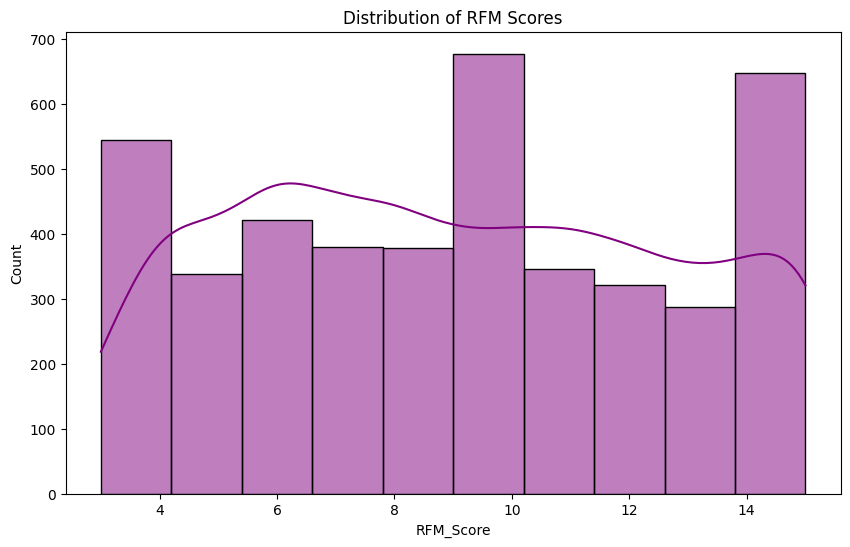

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(rfm['RFM_Score'], bins=10, kde=True, color='purple')
plt.title('Distribution of RFM Scores')

In [ ]:
rfm.to_csv('rfm_segments.csv')
from google.colab import files
files.download('rfm_segments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']]

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)

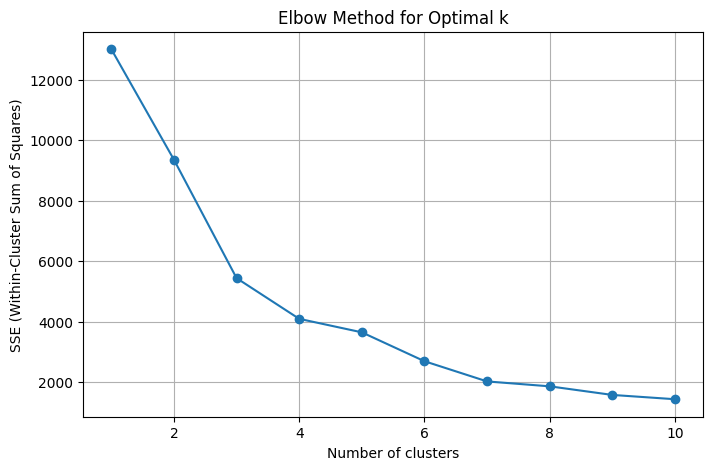

In [ ]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)  # Change 4 if elbow suggests another value
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

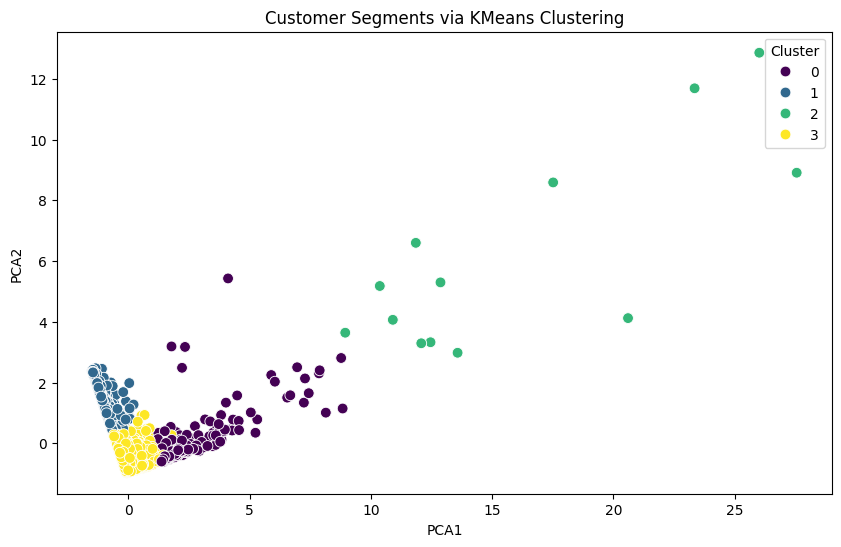

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_components[:,0]
rfm['PCA2'] = pca_components[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=60)
plt.title('Customer Segments via KMeans Clustering')
plt.show()

In [ ]:
rfm['Cluster'] = rfm['Cluster'].astype(int)

In [ ]:
rfm.dtypes

,0
Recency,int64
Frequency,int64
Monetary,float64
R_Score,category
F_Score,category
M_Score,category
RFM_Segment,object
RFM_Score,int64
Cluster,int64
PCA1,float64


In [ ]:
# Step 1: Ensure Cluster is integer
rfm['Cluster'] = rfm['Cluster'].astype(int)

# Step 2: Select only numeric columns
rfm_numeric = rfm.select_dtypes(include=[np.number])

# Step 3: Group by 'Cluster' and calculate mean ONLY on numeric data
rfm_cluster_summary = rfm_numeric.groupby(rfm['Cluster']).mean().round(2)

# Display the result
rfm_cluster_summary

,Recency,Frequency,Monetary,RFM_Score,Cluster,PCA1,PCA2
Cluster,,,,,,,
0,15.67,22.05,12453.23,14.57,0.0,2.58,0.08
1,248.56,1.55,478.11,5.18,1.0,-0.94,1.30
2,7.38,82.69,127338.31,14.62,2.0,16.01,6.20
3,43.92,3.66,1350.14,9.94,3.0,0.08,-0.48


In [ ]:
# Convert category to int
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Now you can include them in your aggregation
numeric_cols = ['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']
rfm_cluster_summary = rfm.groupby('Cluster')[numeric_cols].mean().round(2)

rfm_cluster_summary

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Cluster,,,,,,,
0,15.67,22.05,12453.23,4.62,4.96,4.99,14.57
1,248.56,1.55,478.11,1.19,1.98,2.01,5.18
2,7.38,82.69,127338.31,4.77,4.85,5.00,14.62
3,43.92,3.66,1350.14,3.53,3.21,3.20,9.94


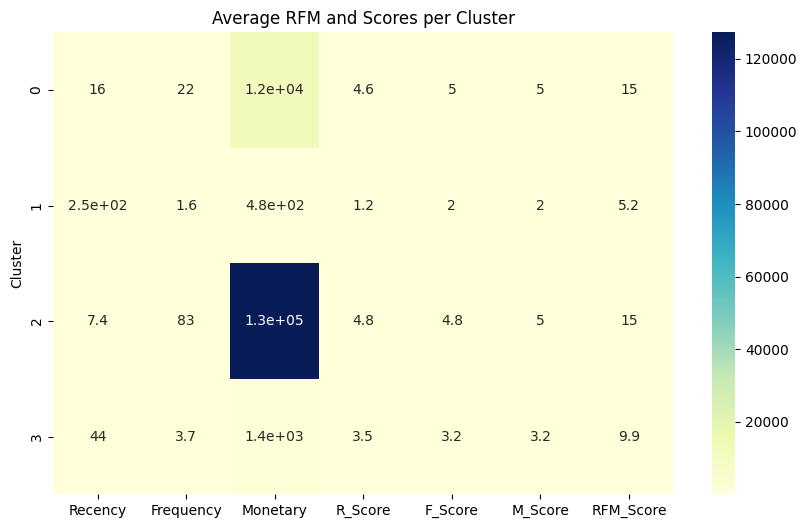

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_cluster_summary, annot=True, cmap='YlGnBu')
plt.title('Average RFM and Scores per Cluster')
plt.show()

In [ ]:
cluster_insights = {
    0: "Champions: Recent, frequent, and high spenders. Target them with exclusive perks and loyalty rewards.",
    1: "At-Risk Customers: High spenders but inactive. Win them back with personalized re-engagement offers.",
    2: "New Customers: Recent sign-ups. Onboard them with welcome messages and first-time offers.",
    3: "Low-Value Customers: Rare and low spenders. Engage with promos and remarketing, but minimize spend."
}

for cluster, insight in cluster_insights.items():
    print(f"Cluster {cluster}: {insight}\n")

Cluster 0: Champions: Recent, frequent, and high spenders. Target them with exclusive perks and loyalty rewards.

Cluster 1: At-Risk Customers: High spenders but inactive. Win them back with personalized re-engagement offers.

Cluster 2: New Customers: Recent sign-ups. Onboard them with welcome messages and first-time offers.

Cluster 3: Low-Value Customers: Rare and low spenders. Engage with promos and remarketing, but minimize spend.

